# Cookbook: Think with Images

In this cookbook, we will demonstrate how to think with images through Qwen3-VL inherent `image_zoom_in_tool` and `image_search` function calls using an agent.

# Install Requirements

We will use [Qwen-Agent](https://github.com/QwenLM/Qwen-Agent) in this book. For demonstration, we need at least the minimal functionality of Qwen-Agent.

In [ ]:
!pip3 install -U "qwen-agent"
# `pip install -U qwen-agent` will install the minimal requirements.
# The optional requirements, specified in double brackets, are:
#   [gui] for Gradio-based GUI support;
#   [rag] for RAG support;
#   [code_interpreter] for Code Interpreter support;
#   [mcp] for MCP support.

# Example 1: Zoom-in Assistant

Using DashScope API or local OpenAI server to create an Qwen-Agent that is capable of:
- Thinking, zooming-in (through function call `image_zoom_in_tool`), and analizing.

Notes: the `bbox_2d` for `image_zoom_in_tool` is relative coords with ranging [0, 1000].

In [ ]:
from qwen_agent.agents import Assistant
from qwen_agent.utils.output_beautify import typewriter_print, multimodal_typewriter_print

# `typewriter_print` prints streaming messages in a non-overlapping manner.

In [2]:
llm_cfg = {
    # Use dashscope API
    # 'model': 'qwen3-vl-plus',
    # 'model_server': 'qwenvl_dashscope',
    # 'api_key': '' # **fill your api key here**
    # Use a model service compatible with the OpenAI API, such as vLLM or Ollama:
    "model_type": "qwenvl_oai",
    "model": "Qwen/Qwen3-VL-2B-Instruct",
    "model_server": "http://localhost:8000/v1",  # base_url, also known as api_base
    "api_key": "EMPTY",
    "generate_cfg": {"top_p": 0.8, "top_k": 20, "temperature": 0.7, "repetition_penalty": 1.0, "presence_penalty": 1.5},
}

analysis_prompt = """Your role is that of a research assistant specializing in visual information. Answer questions about images by looking at them closely and then using research tools. Please follow this structured thinking process and show your work.

Start an iterative loop for each question:

- **First, look closely:** Begin with a detailed description of the image, paying attention to the user's question. List what you can tell just by looking, and what you'll need to look up.
- **Next, find information:** Use a tool to research the things you need to find out.
- **Then, review the findings:** Carefully analyze what the tool tells you and decide on your next action.

Continue this loop until your research is complete.

To finish, bring everything together in a clear, synthesized answer that fully responds to the user's question."""

tools = ["image_zoom_in_tool"]
agent = Assistant(
    llm=llm_cfg,
    function_list=tools,
    system_message=analysis_prompt,
    # [!Optional] We provide `analysis_prompt` to enable VL conduct deep analysis. Otherwise use system_message='' to simply enable the tools.
)

In [9]:
from PIL import Image

img = Image.open("../assets/hopinn.jpg")
messages = []
import base64


def encode_image(image):
    return base64.b64encode(image.tobytes()).decode("utf-8")


messages += [{"role": "user", "content": [{"image": f"data:image/jpeg;base64,{encode_image(img)}"}, {"text": "Where was the picture taken?"}]}]

In [10]:
response_plain_text = ""
for ret_messages in agent.run(messages):
    # `ret_messages` will contain all subsequent messages, consisting of interleaved assistant messages and tool responses
    response_plain_text = multimodal_typewriter_print(ret_messages, response_plain_text)

2025-12-24 21:35:48,321 - base.py - 780 - INFO - ALL tokens: 24, Available tokens: 57838


ModelServiceError: Error code: 400 - {'error': {'message': 'cannot identify image file <_io.BytesIO object at 0x7fedaa2db100> cannot identify image file <_io.BytesIO object at 0x7fedaa2db100>', 'type': 'BadRequestError', 'param': None, 'code': 400}}

# Example 2: Multi-functional Assistant

We will create a assistant that is capable of `searching` and `zooming` to show the multi-functionality of VL agent.

To use serper API that enables searching functionality, we need first `export SERPER_API_KEY=xxx` and `export SERPAPI_IMAGE_SEARCH_KEY=xxx` before we run examples in Qwen-Agent.

In [ ]:
from qwen_agent.agents import Assistant
from qwen_agent.utils.output_beautify import typewriter_print, multimodal_typewriter_print

llm_cfg = {
    # Use dashscope API
    # 'model': 'qwen3-vl-plus',
    # 'model_server': 'qwenvl_dashscope',
    # 'api_key': '' # **fill your api key here**
    # Use a model service compatible with the OpenAI API, such as vLLM or Ollama:
    "model_type": "qwenvl_oai",
    "model": "qwen3-vl-235b-a22b-instruct",
    "model_server": "http://localhost:8000/v1",  # base_url, also known as api_base
    "api_key": "EMPTY",
    "generate_cfg": {"top_p": 0.8, "top_k": 20, "temperature": 0.7, "repetition_penalty": 1.0, "presence_penalty": 1.5},
}

tools = ["image_zoom_in_tool", "image_search"]
agent = Assistant(
    llm=llm_cfg,
    function_list=tools,
    system_message="Use tools to answer.",
)

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {"image": "https://www.gongjiyun.com/assets/QucgbCSISoA7XCxlEI9cVQSOnbd.png"},
            {"text": "Find the most prominet feature of these logos and search who creates them."},
        ],
    }
]

[ANSWER]
Okay, I need to find the most prominent feature of these logos and then search for their creator. The image displays many versions of a cartoon bear, so my first step is to examine the central logo closely to identify its key elements. I will zoom in on the main bear character to get a better look at its features.


[TOOL_CALL] image_zoom_in_tool
{"label": "central bear logo", "bbox_2d": [395, 276, 618, 740], "img_idx": 0}
[TOOL_RESPONSE] image_zoom_in_tool



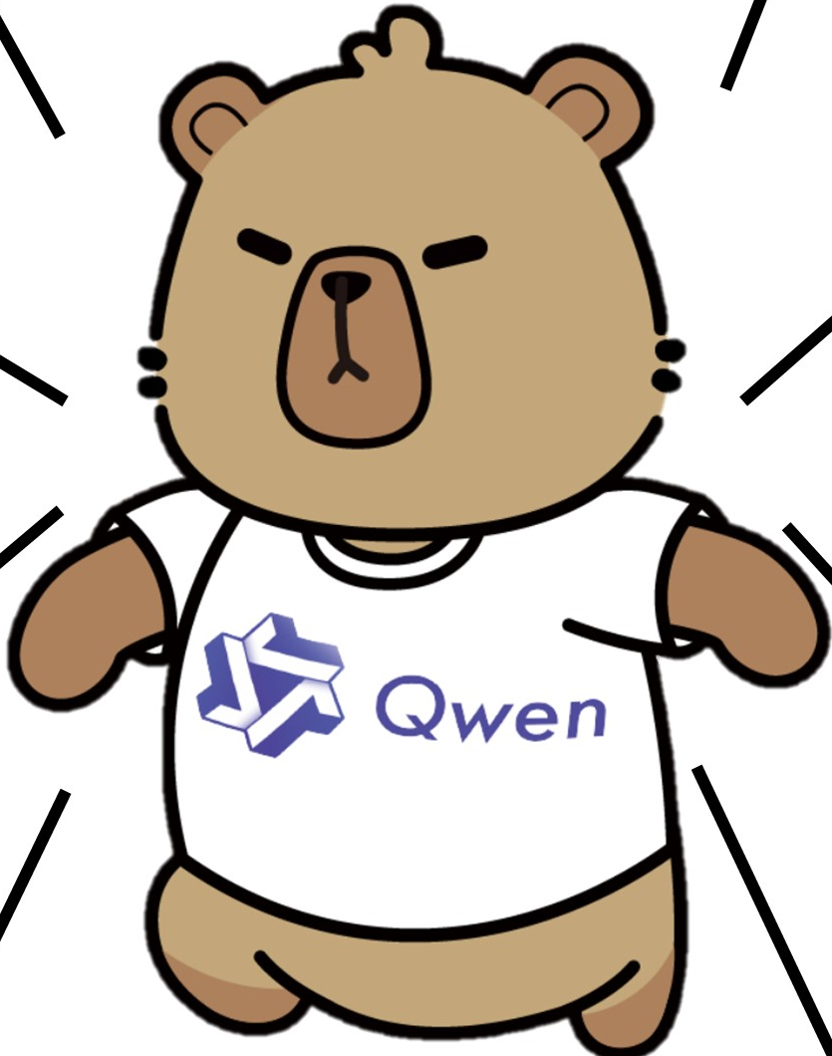


[ANSWER]
Okay, now I see the central logo clearly. The most prominent feature is definitely the cartoon bear character wearing a white t-shirt. On the t-shirt, there's a distinct purple and blue geometric logo next to the word "Qwen" written in a stylized font. This combination of the bear mascot and the specific "Qwen" branding seems to be the core identity. To find out who created these logos, I need to search for this specific combination. I will now perform an image search using the central logo to find its source.


[TOOL_CALL] image_search
{"img_idx": 0}
[TOOL_RESPONSE] image_search
[1] "https://serpapi.com/searches/68d09aba31a601f184b42ebf/images/ce1078c5caa60c0fb6320714422fa42b079069b0c2b582f69da8de6a1fc6db76.jpeg" 刚刚，Qwen-Image图像编辑版本开源了！ - 知乎专栏
Qwen-Image 的图像编辑版本Qwen-Image-Edit 已正式开源。Qwen-Image-Edit是在之前开源20B的Qwen-Image 模型进一步训练的单图编辑模型，不仅支持局部 ...
[2] "https://serpapi.com/searches/68d09aba31a601f184b42ebf/images/ce1078c5caa60c0f939a4be4dee78657a1381fd3669cdd0e00c12aec135be5e9.jp

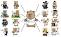

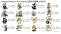

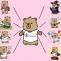

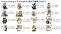

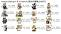


[ANSWER]
Based on the analysis of the provided image and search results, here is the answer to your query:

The most prominent feature of these logos is the **cartoon bear mascot** wearing a white t-shirt with the **"Qwen" brand name and its associated geometric logo**.

This branding is created by **Alibaba's Tongyi Lab (通义实验室)**. The bear is the official mascot for Qwen, which is Alibaba's large language model and AI platform. The search results confirm that the "Qwen-Image-Edit" model, which was used to generate the various poses of the bear in the original image, was developed and released by the Qwen team at Alibaba.

In [ ]:
response_plain_text = ""
for ret_messages in agent.run(messages):
    # `ret_messages` will contain all subsequent messages, consisting of interleaved assistant messages and tool responses
    response_plain_text = multimodal_typewriter_print(ret_messages, response_plain_text)

# Use the GUI

We have explored the capabilities of the Qwen-Agent framework and Qwen models in processing files. We can also achieve this by using the GUI.

In [ ]:
from qwen_agent.gui import WebUI

agent = Assistant(name="Qwen File Processing Assistant", description="I can help with your file processing needs, ask me anything!", llm=llm_cfg, function_list=tools)

WebUI(agent).run()

2025-05-01 21:25:44,068 - mcp_manager.py - 110 - INFO - Initializing MCP tools from mcp servers: ['filesystem', 'mindmap']
2025-05-01 21:25:44,074 - mcp_manager.py - 245 - INFO - Initializing a MCP stdio_client, if this takes forever, please check the config of this mcp server: filesystem
2025-05-01 21:25:45,110 - mcp_manager.py - 245 - INFO - Initializing a MCP stdio_client, if this takes forever, please check the config of this mcp server: mindmap


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
